In [50]:
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import classification_report, plot_confusion_matrix, explained_variance_score, r2_score, mean_absolute_error

from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

In [370]:
def generate_np_data(data, col_x, col_y, look_back, predict_forward, N, categorize = False, zero_missing=True):
    X = []
    Y = []
    
    unique_location = data.wsnm.unique()
    
    dataframe_X = data[['wsnm'] + col_x]
    dataframe_Y = data[['wsnm'] + col_y]
    
    n_samples = 0
    last = -1
    
    for loc in unique_location:
        data_x = np.array(dataframe_X[dataframe_X.wsnm == loc].drop(columns=['wsnm']))
        data_y = np.array(dataframe_Y[dataframe_Y.wsnm == loc].drop(columns=['wsnm']))
        
        for i in range(len(data_x) - look_back - predict_forward):
            x_ = data_x[i:i+look_back]
            y_ = data_y[i+look_back - 1 + predict_forward]

            if not np.isnan(x_).any() and (not np.isnan(y_).any() or zero_missing):
                X.append(x_)
                n_samples += 1

                if zero_missing:
                    if np.isnan(y_).any():
                        Y.append(0)
                    elif categorize:
                        Y.append(1 if y_ > 0 else 0)
                    else:
                        Y.append(y_)
                else:
                    if categorize:
                        Y.append(1 if y_ > 0 else 0)
                    else:
                        Y.append(y_)
                        
            if n_samples % 5000 == 0 and n_samples != last:
                print(n_samples)
                last = n_samples
            if n_samples > N:
                 return np.array(X), np.array(Y)
 
    return np.array(X), np.array(Y)

In [21]:
def get_model_lstm(n_steps, n_features):
    model = Sequential()
    
    model.add(LSTM(128, input_shape=(n_steps, n_features)))

    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =['acc'])
    
    return model

In [85]:
def get_model_lstm_regression(n_steps, n_features, n_output):
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(n_steps, n_features)))

    model.add(Dense(n_output, activation = 'relu'))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics =['mse', 'mae'])
    
    return model

---

# Loading Data|

In [4]:
# https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region
data = pd.read_csv("sudeste.csv")

In [5]:
data.describe()

,wsid,elvt,lat,lon,yr,mo,da,hr,prcp,stp,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
count,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,1.407984e+06,9.779168e+06,...,9.779142e+06,9.778858e+06,9.779134e+06,9.778361e+06,9.779168e+06,9.779156e+06,9.779124e+06,8.853607e+06,9.779168e+06,9.462694e+06
mean,3.592531e+02,5.940923e+02,-2.023082e+01,-4.464590e+01,2.011164e+03,6.521960e+00,1.575465e+01,1.150000e+01,9.366544e-01,8.804292e+02,...,2.110503e+01,1.524025e+01,1.986418e+01,1.422089e+01,6.726667e+01,6.996991e+01,6.441965e+01,1.998156e+00,1.385991e+02,4.494015e+00
std,3.901630e+01,3.980379e+02,3.172643e+00,4.882117e+00,3.207774e+00,3.425538e+00,8.802154e+00,6.922190e+00,2.923291e+00,2.482650e+02,...,7.545549e+00,5.866811e+00,7.134849e+00,5.777089e+00,2.654213e+01,2.643371e+01,2.656550e+01,1.618531e+00,1.052018e+02,2.981790e+00
min,1.780000e+02,0.000000e+00,-2.496282e+01,-5.667732e+01,2.000000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.200000e+00,-1.000000e+01,-8.500000e+00,-1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.280000e+02,2.830000e+02,-2.239580e+01,-4.743410e+01,2.009000e+03,4.000000e+00,8.000000e+00,5.000000e+00,0.000000e+00,9.113000e+02,...,1.820000e+01,1.270000e+01,1.720000e+01,1.160000e+01,5.300000e+01,5.800000e+01,4.900000e+01,8.000000e-01,5.600000e+01,2.300000e+00
50%,3.580000e+02,5.730000e+02,-2.075041e+01,-4.445378e+01,2.011000e+03,7.000000e+00,1.600000e+01,1.200000e+01,0.000000e+00,9.442000e+02,...,2.190000e+01,1.660000e+01,2.080000e+01,1.560000e+01,7.400000e+01,7.800000e+01,7.000000e+01,1.700000e+00,1.140000e+02,4.200000e+00
75%,3.940000e+02,8.750000e+02,-1.891707e+01,-4.243575e+01,2.014000e+03,9.000000e+00,2.300000e+01,1.800000e+01,6.000000e-01,9.731000e+02,...,2.580000e+01,1.940000e+01,2.420000e+01,1.840000e+01,8.900000e+01,9.100000e+01,8.600000e+01,2.900000e+00,2.160000e+02,6.300000e+00
max,4.230000e+02,1.758000e+03,0.000000e+00,0.000000e+00,2.016000e+03,1.200000e+01,3.100000e+01,2.300000e+01,1.000000e+02,1.050000e+03,...,4.500000e+01,4.480000e+01,4.500000e+01,4.490000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.980000e+01,3.600000e+02,5.000000e+01


In [247]:
data.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 00:00:00,2007-11-06,...,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 01:00:00,2007-11-06,...,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 02:00:00,2007-11-06,...,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 03:00:00,2007-11-06,...,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 04:00:00,2007-11-06,...,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [249]:
data.wsnm.unique()

array(['SÃO GONÇALO', 'VITÓRIA', 'SANTA TERESA', 'LINHARES',
       'ALFREDO CHAVES', 'SÃO MATEUS', 'ALEGRE', 'PRES. KENNEDY',
       'NOVA VENECIA', 'AFONSO CLAUDIO', 'BARBACENA', 'ARAXÁ',
       'MONTES CLAROS', 'UBERLÂNDIA', 'ALMENARA', 'MONTE VERDE', 'VIÇOSA',
       'TIMÓTEO', 'ITUIUTABA', 'OURO BRANCO', 'S.J.DEL REI', 'VARGINHA',
       'PASSOS', 'MURIAÉ', 'JUÍZ DE FORA', 'CAMPINA VERDE',
       'CONC. DAS ALAGOAS', 'BELO HOR. (PAMPULHA)', 'SERRA DOS AIMORES',
       'PATROCÍNIO', 'FORMIGA', 'SACRAMENTO', 'MONTALVANIA',
       'TEÓFILO OTONI', 'TRÊS MARIAS', 'PASSA QUATRO', 'CALDAS',
       'MARIA DA FÉ', 'GOVERNADOR VALADARES', 'GUANHÃES', 'AIMORES',
       'FLORESTAL', 'DORES DO INDAIÁ', 'DIAMANTINA', 'CURVELO',
       'MOCAMBINHO', 'MANTENA', 'CAPELINHA', 'UNAI', 'ESPINOSA',
       'BURITIS', 'PIRAPORA', 'GUARDA-MOR', 'SÃO ROMÃO', 'CHAPADA GAÚCHA',
       'ÁGUAS VERMELHAS', 'ITAOBIM', 'RIO PARDO DE MINAS', 'SALINAS',
       'JOÃO PINHEIRO', 'CARATINGA', 'IBIRITÈ (ROLA MOÇA)', 

__wsid__:
- Weather station id

__wsnm__:
- Name station (usually city location or nickname)

__evlt__:
- Elevation

__elvt__:
- Elevation

__lat__:
- Latitude

__lon__:
- Longitude

__inme__:
- Station number (INMET number) for the location

__city__:
- City

__prov__:
- State (Province)

__date__:
- Date of observation
    
__yr__:
- The year (2000-2016)

__mo__:
- The month (0-12)

__da__:
- The day (0-31)

__hr__:
- The hour (0-23)

__prcp__:
- Amount of precipitation in millimetres (last hour)

__stp__:
- Air pressure for the hour in hPa to tenths (instant)

__smax__:
- Maximum air pressure for the last hour in hPa to tenths

__smin__:
- Minimum air pressure for the last hour in hPa to tenths

__gbrd__:
- Solar radiation KJ/m2

__temp__:
- Air temperature (instant) in celsius degrees

__dewp__:
- Dew point temperature (instant) in celsius degrees

__dmax__:
- Maximum dew point temperature for the last hour in celsius degrees

__dmin__:
- Minimum dew point temperature for the last hour in celsius degrees

__hmax__:
- Maximum relative humid temperature for the last hour in %

__hmin__:
- Minimum relative humid temperature for the last hour in %

__wdsp__:
- Wind speed in metres per second

__wdct__:
- Wind direction in radius degrees (0-360)

__gust__:
- Wind gust in metres per second

---

## Correlation Map

<AxesSubplot:>

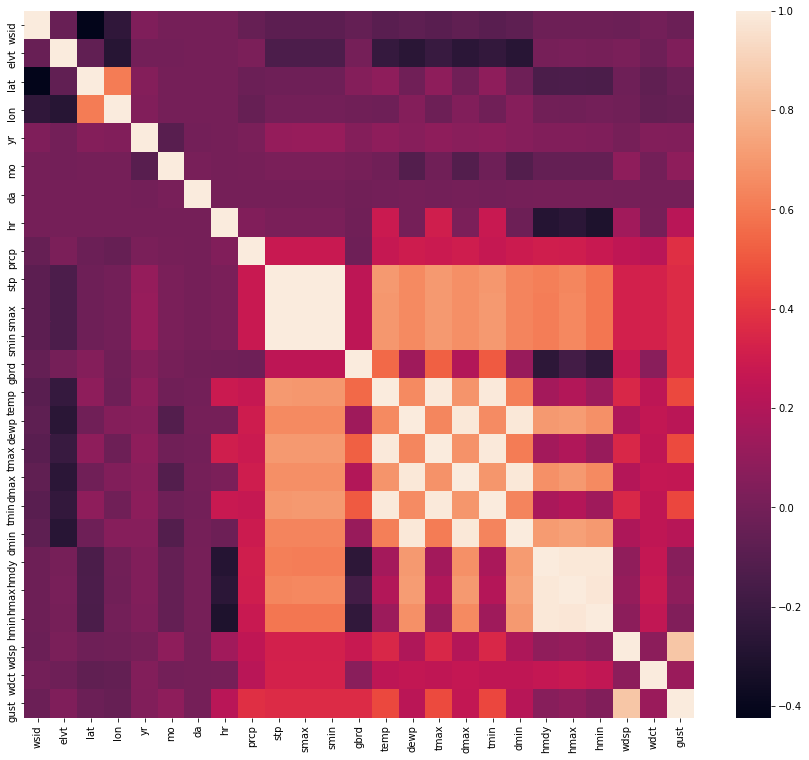

In [6]:
plt.rcParams["figure.figsize"] = [15,13]
sbs.heatmap(data.corr())

## Histogram

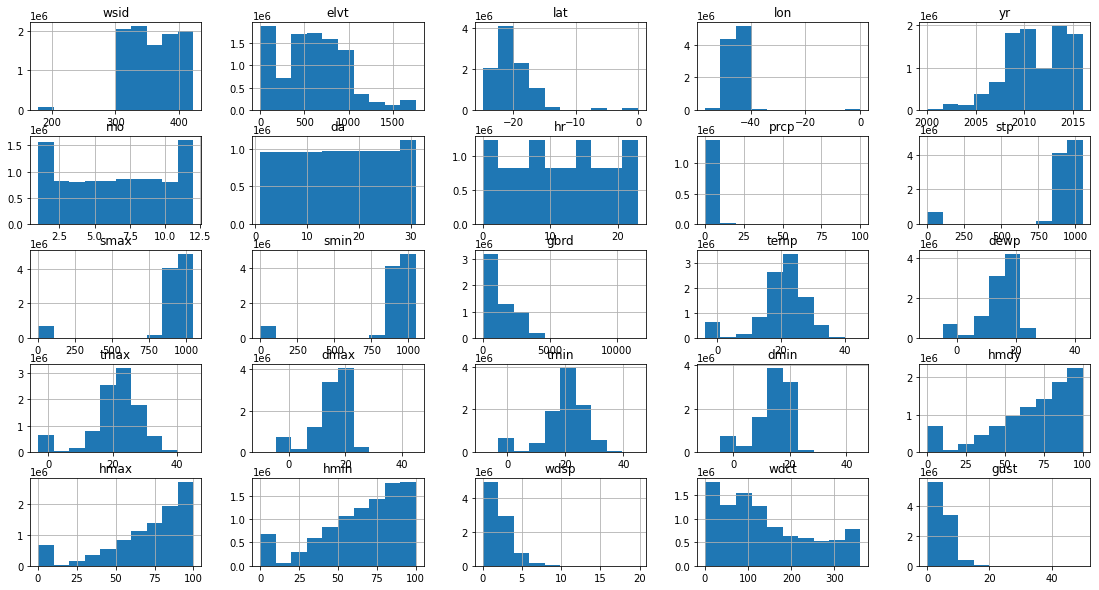

In [7]:
plt.rcParams["figure.figsize"] = [19,10]
data.hist()
plt.show()

---

# Predicting Amount of Precipitation of next 24 hours

## From stp, temp, hmin, hmax, wdsp of last 12 hours

In [412]:
x_col = ['hr', 'stp', 'temp', 'hmin', 'hmax', 'wdsp']
y_col = ['prcp']

In [413]:
look_back = 12
predict_forward = 24
N = 100000

X, Y = generate_np_data(data, x_col, y_col, look_back, predict_forward, N, True, False)

train_size = 0.9

X_train, X_test = X[0:int(train_size * len(X))], X[int(train_size * len(X)):]
y_train, y_test = Y[0:int(train_size * len(Y))], Y[int(train_size * len(Y)):]

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
X_train shape (90000, 12, 6)
y_train shape (90000,)


## Using Random Forest, N Trees = 100

In [414]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=8)

In [ ]:
s_x = X_train.shape

rf.fit(X_train.reshape(s_x[0], s_x[1] * s_x[2]), y_train)

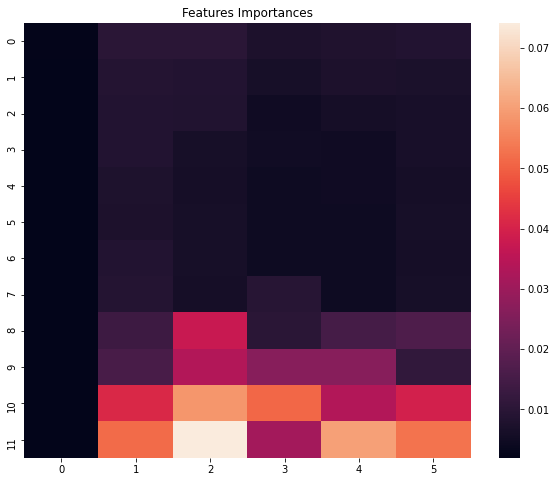

In [375]:
sbs.heatmap(rf.feature_importances_.reshape(s_x[1], s_x[2])).set_title("Features Importances")
plt.show()

### Results

In [409]:
s_x = X_test.shape

plt.rcParams["figure.figsize"] = [10,8]
plot_confusion_matrix(rf, X_test.reshape(s_x[0], s_x[1] * s_x[2]), y_test, normalize='total', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

ValueError: plot_confusion_matrix only supports classifiers

In [377]:
y_pred = rf.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      7736
           1       0.84      0.93      0.88      2265

    accuracy                           0.94     10001
   macro avg       0.91      0.94      0.92     10001
weighted avg       0.95      0.94      0.95     10001



---

## Using Gaussian Naive Bayes

In [378]:
nb = GaussianNB()

In [379]:
s_x = X_train.shape

nb.fit(X_train.reshape(s_x[0], s_x[1] * s_x[2]), y_train)

GaussianNB()

### Results

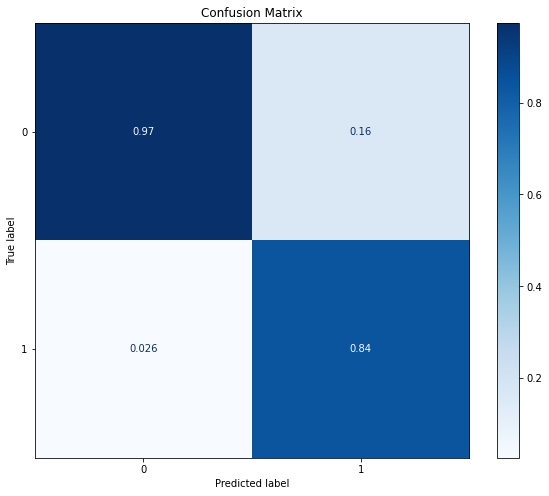

In [380]:
s_x = X_test.shape

plt.rcParams["figure.figsize"] = [10,8]
plot_confusion_matrix(nb, X_test.reshape(s_x[0], s_x[1] * s_x[2]), y_test, normalize='pred', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [381]:
y_pred = nb.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7736
           1       0.84      0.91      0.88      2265

    accuracy                           0.94     10001
   macro avg       0.91      0.93      0.92     10001
weighted avg       0.94      0.94      0.94     10001



---

## Using LSTM

In [382]:
model = get_model_lstm(look_back, X_train.shape[2])

In [383]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=64, epochs=10)

Epoch 1/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.3245 - acc: 0.8846 - val_loss: 0.1508 - val_acc: 0.9476
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3176 - acc: 0.8869 - val_loss: 0.1507 - val_acc: 0.9463
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3142 - acc: 0.8870 - val_loss: 0.1511 - val_acc: 0.9473
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3113 - acc: 0.8873 - val_loss: 0.1480 - val_acc: 0.9480
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3102 - acc: 0.8874 - val_loss: 0.1506 - val_acc: 0.9475
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3102 - acc: 0.8877 - val_loss: 0.1482 - val_acc: 0.9470
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3095 - acc: 0.8878 - val_loss: 0.1486 - val_acc: 0.9467
Epoch 8/10
1407/1407 [==============================] - 7s 5ms

In [384]:
y_pred = model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      7736
           1       0.83      0.97      0.89      2265

    accuracy                           0.95     10001
   macro avg       0.91      0.95      0.93     10001
weighted avg       0.95      0.95      0.95     10001



---

# Predicting Wind Speed and Direction of next 6 hours

### From stp, temp, hmin, hmax, wdsp, wdct, prcp of last 16 hours

In [385]:
x_col = ['hr', 'stp', 'temp', 'hmin', 'hmax', 'wdsp', 'wdct', 'prcp']
y_col = ['wdsp', 'wdct']

In [386]:
look_back = 16
predict_forward = 6
N = 100000

X, Y = generate_np_data(data, x_col, y_col, look_back, predict_forward, N, False, False)

train_size = 0.8

X_train, X_test = X[0:int(train_size * len(X))], X[int(train_size * len(X)):]
y_train, y_test = Y[0:int(train_size * len(Y))], Y[int(train_size * len(Y)):]

print("X_train shape", X_train.shape)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
X_train shape (80000, 16, 8)


## Using Random Forest, N Trees = 150

In [387]:
rf = RandomForestRegressor(n_estimators=150, n_jobs=8)

In [388]:
s_x = X_train.shape

rf.fit(X_train.reshape(s_x[0], s_x[1] * s_x[2]), y_train)

RandomForestRegressor(n_estimators=150, n_jobs=8)

### Results

In [389]:
s_x = X_test.shape
y_pred = rf.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))

In [390]:
r2_tree = r2_score(y_test, y_pred, multioutput='raw_values')
mae_tree = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [391]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_tree)
print("Mean Absolute Error for each value (less is better):", mae_tree)

R^2 Score for each value (1 is the best, 0 is the worse): [0.68495136 0.67204035]
Mean Absolute Error for each value (less is better): [ 0.27032598 18.99468303]


---

## Using Elastic Net

In [392]:
en = ElasticNet(max_iter=5000)

In [393]:
s_x = X_train.shape

en.fit(X_train.reshape(s_x[0], s_x[1] * s_x[2]), y_train)

ElasticNet(max_iter=5000)

### Results

In [394]:
s_x = X_test.shape
y_pred = en.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))

In [395]:
r2_en = r2_score(y_test, y_pred, multioutput='raw_values')
mae_en = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [396]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_en)
print("Mean Absolute Error for each value (less is better):", mae_en)

R^2 Score for each value (1 is the best, 0 is the worse): [0.64036957 0.65877966]
Mean Absolute Error for each value (less is better): [ 0.29163315 19.66006781]


---

## Using LSTM

In [397]:
model = get_model_lstm_regression(look_back, X_train.shape[2], len(y_train.shape))

In [398]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=64, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1930.3030 - mse: 1930.3030 - mae: 12.3404 - val_loss: 1423.9072 - val_mse: 1423.9072 - val_mae: 10.7283
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1279.4680 - mse: 1279.4680 - mae: 10.6113 - val_loss: 1196.1154 - val_mse: 1196.1154 - val_mae: 9.5924
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1230.6616 - mse: 1230.6616 - mae: 10.6159 - val_loss: 1171.4606 - val_mse: 1171.4606 - val_mae: 10.5357
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1217.5577 - mse: 1217.5577 - mae: 10.5660 - val_loss: 1175.2223 - val_mse: 1175.2223 - val_mae: 9.7252
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1205.2668 - mse: 1205.2668 - mae: 10.4761 - val_loss: 1148.7130 - val_mse: 1148.7130 - val_mae: 10.6043
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1201.8616 - mse: 1201.8616

### Results

In [399]:
s_x = X_test.shape
y_pred = model.predict(X_test)

In [400]:
r2_lstm = r2_score(y_test, y_pred, multioutput='raw_values')
mae_lstm = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [401]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_lstm)
print("Mean Absolute Error for each value (less is better):", mae_lstm)

R^2 Score for each value (1 is the best, 0 is the worse): [0.59152257 0.64960689]
Mean Absolute Error for each value (less is better): [ 0.29996918 19.66878213]


---

In [402]:
print("Mean R^2 Score Random Forest:", np.round(np.mean(r2_tree), 3))
print("Mean R^2 Score Elastic Net:", np.round(np.mean(r2_en), 3))
print("Mean R^2 Score LSTM:", np.round(np.mean(r2_lstm), 3))

Mean R^2 Score Random Forest: 0.678
Mean R^2 Score Elastic Net: 0.65
Mean R^2 Score LSTM: 0.621


In [403]:
print("Mean MAE Random Forest:", np.round(np.mean(mae_tree), 3))
print("Mean MAE Elastic Net:", np.round(np.mean(mae_en), 3))
print("Mean MAE LSTM:", np.round(np.mean(mae_lstm), 3))

Mean MAE Random Forest: 9.633
Mean MAE Elastic Net: 9.976
Mean MAE LSTM: 9.984
